# Dates for Olist Brazilian e-commerce


In [1]:
import matplotlib.pyplot as plt
import os
from pathlib import Path
import pandas as pd
import yaml
# Get the current project path (where you open the notebook)
# and go up two levels to get the project path
current_dir = Path.cwd()
proj_path = current_dir.parent.parent
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta

# make the code in src available to import in this notebook
import sys
sys.path.append(os.path.join(proj_path, 'src'))

# Custom functions and classes
from utils import make_dates, create_folder

# Catalog contains all the paths related to datasets
with open(os.path.join(proj_path, 'conf/catalog.yml'), "r") as f:
    catalog = yaml.safe_load(f)['olist']
    
# Params contains all of the dataset creation parameters and model parameters
with open(os.path.join(proj_path, 'conf/params.yml'), "r") as f:
    params = yaml.safe_load(f)

In [2]:
date_ranges = make_dates(params['olist']['experiment_dates'])

In [3]:
date_ranges

,train_start,train_end,valid_start,valid_end,test_start,test_end
0,2017-01-01,2017-12-03,2017-12-10,2017-12-31,2018-01-07,2018-01-28
1,2017-01-29,2017-12-31,2018-01-07,2018-01-28,2018-02-04,2018-02-25
2,2017-02-26,2018-01-28,2018-02-04,2018-02-25,2018-03-04,2018-03-25
3,2017-03-26,2018-02-25,2018-03-04,2018-03-25,2018-04-01,2018-04-22
4,2017-04-23,2018-03-25,2018-04-01,2018-04-22,2018-04-29,2018-05-20
5,2017-05-21,2018-04-22,2018-04-29,2018-05-20,2018-05-27,2018-06-17
6,2017-06-18,2018-05-20,2018-05-27,2018-06-17,2018-06-24,2018-07-15
7,2017-07-16,2018-06-17,2018-06-24,2018-07-15,2018-07-22,2018-08-12


# Methodology

The start date of the experiment is 2017-01-01 and the end date of the experiment is 2018-08-12.  

We will use the last 32 weeks as our test data, covering inclusively the dates from 2018-01-07 to 2018-08-12.  

Will will use sequences of 4 weeks to create our cross-validation folds over the test period.  Bollow is an illustration for the different folds.  

In [4]:
def show_windows(dates: pd.DataFrame, fname=None):
    """Generate a plot to view the time of the different folds.
    
    fname to save plot, specify a path.
    """
    # Register a date converter from pandas to work with matplotlib
    register_matplotlib_converters()

    mi = dates["train_start"].min() - relativedelta(weeks=1)
    ma = dates["test_end"].max() + relativedelta(weeks=1)

    plt.figure(figsize=(16, 5))
    plt.scatter(x=[mi, ma], y=[0, 0], alpha=0)
    for i, date_range in enumerate(dates.sort_values("train_start").itertuples()):

        # Width of bar in days
        train_len = (date_range[3] - date_range[1]).days
        valid_len = (date_range[4] - date_range[2]).days
        test_len = (date_range[6] - date_range[4]).days

        plt.barh(y=i, width=train_len, left=date_range[1], color="#C5CAE9")
        plt.barh(y=i, width=valid_len, left=date_range[3], color="#2196F3")
        plt.barh(y=i, width=test_len, left=date_range[5], color="#1A237E")
        plt.xticks(rotation=45)
        plt.ylabel("Fold Id")

    plt.title("Cross-Validation Through Time")
    plt.legend(["", "Train period", "Valid period", "Test period"])
    if fname:
        plt.savefig(fname)
    plt.show()

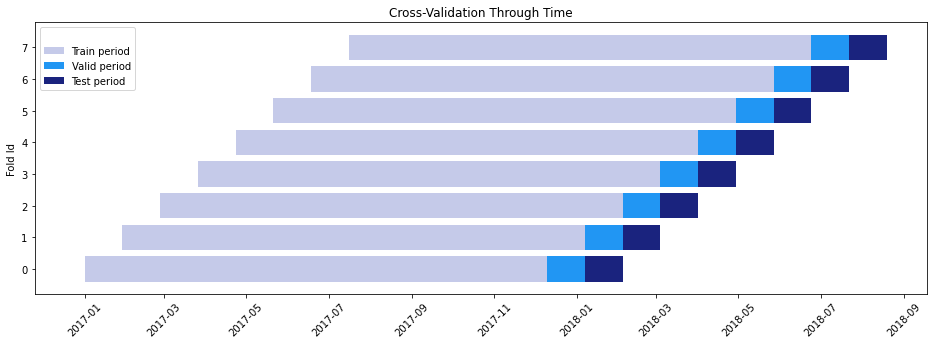

In [5]:
show_windows(date_ranges)

We use January 2018 data as the start of the test dataset up to September, using folds of 4 weeks. The same length is used as the validation period.

Additional precision on the dates:

For the Olist dataset, when aggregating by weekly values, we obtain the end of the week sales. We use the payment_value as the target value.

The sales at (2018-07-01) are from (2018-06-25) to (2018-07-01) inclusively. 

```python
"""
date at time t-N     |    ...    |    (2018-07-01)   |   (2018-07-08)  
payment_value t-N    |    ...    | payment_value t-1 |   payment_value  
---------------------|-----------|-------------------|------------------  
     115             |    ...    |        80         |        70  
"""
```
     
For Incorperating Google Trends, we obtain the date at the begining of the week. This means that by adding 7 days, we can align the google trends values to the payment_values. In our usecase, however, we cannot use values gathered from (2018-07-05, 2018-07-06, ...) because the time when we make the forecast is at time (2018-07-01). Thus, we will add + 7 again to the google trends, so that when we use google trends data to forecast the payment_value, we only use google trends that go up to the payment_value t-1 date.



